# Scope of this notebook:
    Q.5: Gibbs sampling histograms and fitted pdf curves, burn-in period and sample size analysis
    Q.6: posterior skills update with match result obervations via Gibbs sampling (SerieA)
    Q.7: accuracy within the one-step-ahead prediction procedure for match results (SerieA)
    Q.11: convergence for hyperparameter tuning (variance for the match result variable t) if needed (serieA)
    Q.9: message-passing vs. Gibbs sampling for approximation of posterior skills
    Q.10: accuracy within the one-step-ahead prediction procedure for match results (our data, NBA 2021/22)

In [56]:
import numpy as np
from scipy import stats
from scipy import optimize as opt
import matplotlib.pyplot as plt
import pandas as pd

# Question 5

In [57]:
def approx_gaussian(samples, importances):
    mu = np.average(samples, weights=importances)
    var = np.average((samples - mu) ** 2, weights=importances)
    return mu, var

def importance(s1, s2, s_e, y=1):
    pr = 1 - stats.norm(s1 - s2, s_e ** 0.5).cdf(0) if y > 0 else stats.norm(s1 - s2, s_e ** 0.5).cdf(0)
    return pr

In [58]:
m1, m2 = 0, 0 # prior mean for s1 and s2
v1, v2 = 1, 1 # prior variance for s1 and s2
s_e = 1 # variance for the variable t = s1 - s2 (hyperparameter)

num_samples = 5000

# observed results
ys = [1,]

for y in ys: 
    posterior = []
    post_weights = []
    s1 = 0
    s1_w = 1

    for _ in range(num_samples):
        s2 = stats.norm.rvs(m2, v2**0.5)
        s2_w = importance(s1, s2, s_e, y)
        
        posterior.append((s1, s2))
        post_weights.append((s1_w, s2_w))

        s1 = stats.norm.rvs(m1, v1**0.5)
        s1_w = importance(s1, s2, s_e, y)

    posterior = np.array(posterior)
    post_weights = np.array(post_weights)

### Burn-in period

### We use summary statistics to determine the burn-in period

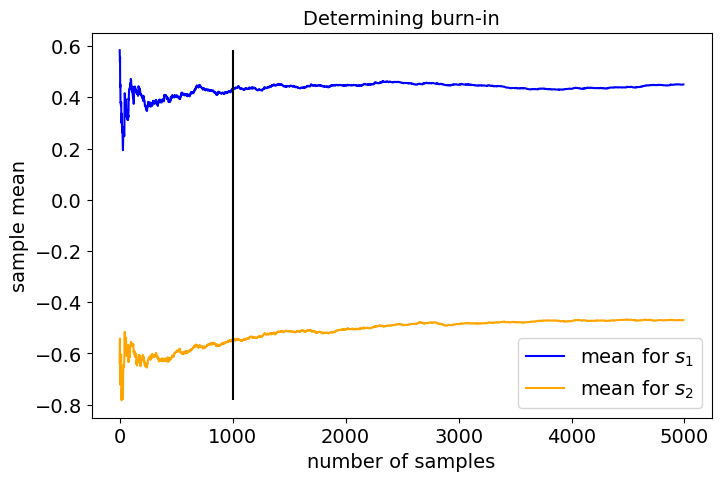

In [59]:
## Nice convergence for s1 and s2 sample mean (and variance)

mean_convergence = []
var_convergence = []
for sample_size in range(10, num_samples + 1):
    m1, v1 = approx_gaussian(posterior[:sample_size, 0], post_weights[:sample_size, 0])
    m2, v2 = approx_gaussian(posterior[:sample_size, 1], post_weights[:sample_size, 1])
    mean_convergence.append((m1, m2))
    var_convergence.append((v1, v2))
    
mean_convergence = np.array(mean_convergence)
var_convergence = np.array(var_convergence)

plt.figure(figsize=(8, 5))
plt.title("Determining burn-in", fontsize=14)
plt.plot(mean_convergence[:, 0], c='b', label=r'mean for $s_1$')
plt.plot(mean_convergence[:, 1], c='orange', label=r'mean for $s_2$')
plt.vlines(1000, np.min(mean_convergence), np.max(mean_convergence), color='k')
plt.legend(fontsize=14)
plt.xlabel("number of samples", fontsize=14)
plt.ylabel("sample mean", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()


## Uncomment if plots for variance are of interest
# plt.figure(figsize=(8, 5))
# plt.title("Determining burn-in", fontsize=14)
# plt.plot(var_convergence[:, 0], c='b', label=r'var for $s_1$')
# plt.plot(var_convergence[:, 1], c='orange', label=r'var for $s_2$')
# plt.vlines(drops, np.min(var_convergence), np.max(var_convergence), color='k')
# plt.legend(fontsize=14)
# plt.xlabel("number of samples", fontsize=14)
# plt.ylabel("sample variance", fontsize=14)
# plt.xticks(fontsize=14)
# plt.yticks(fontsize=14)
# plt.show()

### Histogram for Gibbs samples and PDF fitted to it

### From the burn-in analysis we estimate the burn-in period equal to 1000

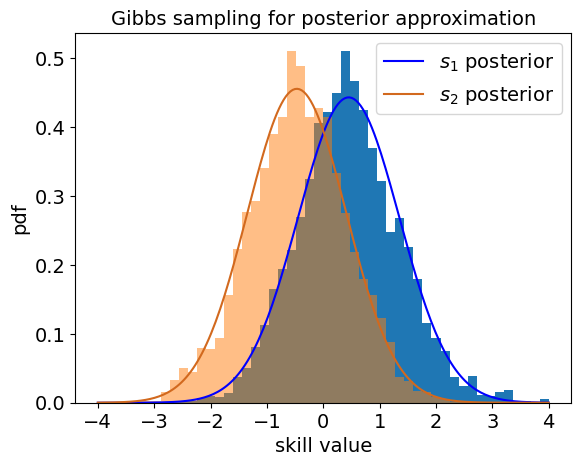

In [60]:
drops = 1000 # drop samples before within burn-in period

plt.hist(posterior[drops:,0], density=True, weights=post_weights[drops:,0], bins=50, range=(-4, 4))
plt.hist(posterior[drops:,1], density=True, weights=post_weights[drops:,1], bins=50, range=(-4, 4), alpha=0.5)

xs = np.linspace(-4, 4, 200)
gaussian1 = stats.norm(m1, v1**0.5).pdf(xs)
gaussian2 = stats.norm(m2, v2**0.5).pdf(xs)
plt.plot(xs, gaussian1, color='blue', label='$s_1$ posterior')
plt.plot(xs, gaussian2, color='chocolate', label='$s_2$ posterior')
plt.legend(fontsize=14)
plt.title("Gibbs sampling for posterior approximation", fontsize=14)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xlabel("skill value", fontsize=14)
plt.ylabel("pdf", fontsize=14)
plt.show()

### Analysis of sample size

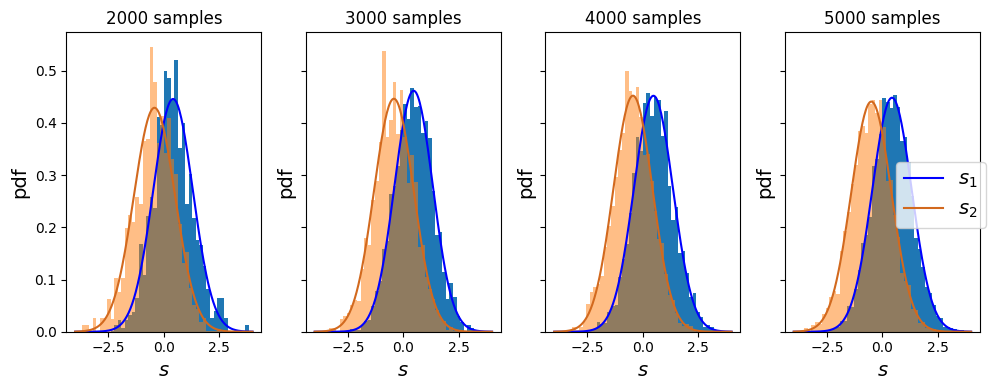

In [61]:
sample_sizes = (2000, 3000, 4000, 5000)
s_e = 1

mean = []
var = []
samples = []
weights = []
for num_samples in sample_sizes:

    m1, m2 = 0, 0
    v1, v2 = 1, 1

    posterior = []
    post_weights = []
    s1 = 0
    s1_w = 1

    for _ in range(num_samples):
        s2 = stats.norm.rvs(m2, v2**0.5)
        s2_w = importance(s1, s2, s_e, y)

        posterior.append((s1, s2))
        post_weights.append((s1_w, s2_w))

        s1 = stats.norm.rvs(m1, v1**0.5)
        s1_w = importance(s1, s2, s_e, y)
        
    posterior = np.array(posterior)
    post_weights = np.array(post_weights)

    samples.append(posterior)
    weights.append(post_weights)

    m1, v1 = approx_gaussian(posterior[drops:, 0], post_weights[drops:, 0])
    m2, v2 = approx_gaussian(posterior[drops:, 1], post_weights[drops:, 1])
    mean.append((m1, m2))
    var.append((v1, v2))

mean = np.array(mean)
var = np.array(var)

fig, axs = plt.subplots(1, 4, sharey=True, figsize=(10, 4))
xs = np.linspace(-4, 4, 200)

for i in range(len(axs)):
    axs[i].hist(samples[i][drops:,0], density=True, weights=weights[i][drops:,0], bins=50, range=(-4, 4))
    axs[i].hist(samples[i][drops:,1], density=True, weights=weights[i][drops:,1], bins=50, range=(-4, 4), alpha=0.5)    
    axs[i].plot(xs, stats.norm(mean[i][0], var[i][0]**0.5).pdf(xs), color='blue', label=r'$s_1$')
    axs[i].plot(xs, stats.norm(mean[i][1], var[i][1]**0.5).pdf(xs), color='chocolate', label=r'$s_2$')
    axs[i].set_title(f"{sample_sizes[i]} samples")
    axs[i].set_xlabel("$s$", fontsize=14)
    axs[i].set_ylabel("pdf", fontsize=14)
    
handles, labels = axs[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='center right', fontsize=14)
fig.tight_layout()

### Posterior vs. prior

In [ ]:
xs = np.linspace(-4, 4, 200)
prior_gaussian1 = stats.norm(0, 1).pdf(xs)
post_gaussian1 = stats.norm(m1, v1**0.5).pdf(xs)
post_gaussian2 = stats.norm(m2, v2**0.5).pdf(xs)
plt.plot(xs, prior_gaussian1, '--', color='blue', label=r'prior for $s_1$ and $s_2$')
plt.plot(xs, post_gaussian1, color='blue', label=r'posterior for $s_1$')
plt.plot(xs, post_gaussian2, color='chocolate', label=r'posterior for $s_2$')
plt.legend(fontsize=12)
plt.xlabel("skill value", fontsize=12)
plt.ylabel("pdf", fontsize=12)

# Question 6 and 7 ( + Question 11 by user's choice)

In [8]:
# Tune variance for t to replace S_E if needed
def tune_match_variance(t, m1, m2, v1, v2, s0):
    '''s_e = argmax(Marginal Likelihood for data given in array t)'''
    # marginal loglikelihood for optimization
    def cost_func(sigma):
        s = sigma + v1 + v2 # sigma = \sigma_t^2
        return np.sum( np.log(s) + (t - (m1 - m2))**2 / s )
    
    # derivative of marginal loglikelihood for optimization
    def cost_func_grad(sigma):
        s = sigma + v1 + v2
        return np.sum( s**(-1) - (t - (m1 - m2))**2 * s**(-2) )

    opt_res = opt.minimize(cost_func, x0=s0, method='cg', jac=cost_func_grad)
    s_e = float(opt_res.x)
    return s_e

In [10]:
S_E = (25/6)**2 # variance for the variable t = s1 - s2 (hyperparameter)

class Skill:
    def __init__(self, mu=25, var=(25/3)**2):
        self.mu = mu
        self.var = var


class Team:
    def __init__(self, name, skill):
        self.name = name
        self.skill = skill

    def predict(self, another, s_e=S_E):
        lose_rate = stats.norm.cdf(x=0,
                                   loc=self.skill.mu - another.skill.mu,
                                   scale=(self.skill.var + another.skill.var + s_e) ** 0.5)
        win_rate = 1 - lose_rate
        return win_rate

    def update(self, another, result, s_e=S_E, num_samples=3000, drops=1000):
        posterior = []
        post_weights = []
        s1 = self.skill.mu
        s1_w = self.skill.var

        for _ in range(num_samples):
            s2 = stats.norm.rvs(another.skill.mu, another.skill.var ** 0.5)
            s2_w = self._importance(s1, s2, s_e, result)

            posterior.append((s1, s2))
            post_weights.append((s1_w, s2_w))

            s1 = stats.norm.rvs(self.skill.mu, self.skill.var ** 0.5)
            s1_w = self._importance(s1, s2, s_e, result)

        posterior = np.array(posterior)
        post_weights = np.array(post_weights)

        self.skill.mu, self.skill.var = self._approx_gaussian(posterior[drops:, 0], post_weights[drops:, 0])
        another.skill.mu, another.skill.var = self._approx_gaussian(posterior[drops:, 1], post_weights[drops:, 1])
        
    
    @staticmethod
    def _approx_gaussian(samples, importances):
        mu = np.average(samples, weights=importances)
        var = np.average((samples - mu) ** 2, weights=importances)
        return mu, var

    @staticmethod
    def _importance(s1, s2, s_e, y=1):
        pr = 1 - stats.norm(s1 - s2, s_e ** 0.5).cdf(0) if y > 0 else stats.norm(s1 - s2, s_e ** 0.5).cdf(0)
        return pr

### Read data for SerieA competition

In [11]:
df = pd.read_csv('SerieA.csv', sep=',', header=0)
data = df.to_numpy()

teams = {name: Team(name,
                    Skill()) for name in np.unique(data[:, 2:4])}

user_choice = input("Do you want to tune variance for a match result (y/n)?\n")
TUNE_VAR = True if (user_choice.lower() == "y") else False

Do you want to tune variance for a match result (y/n)?
n


In [12]:
num_predictions = 0
correct_predictions = 0

# for tuning match variance
if TUNE_VAR:
    t_arr = np.empty((0))
    m_arr = np.empty((0, 2))
    v_arr = np.empty((0, 2))
    s_e_conv = [] # convergence history for hyperparameter tuning
    s_e = S_E

### Predict match result and update the posterior one-step-ahead

In [13]:
for match in data:

    team1 = teams[match[2]]
    team2 = teams[match[3]]

    # skip draws
    if match[4] == match[5]:
        continue
        
    # for tuning match variance
    if TUNE_VAR:
        t_arr = np.append(t_arr, team2.skill.mu - team2.skill.var)
        m_arr = np.append(m_arr, [[team1.skill.mu, team2.skill.mu]], axis=0)
        v_arr = np.append(v_arr, [[team1.skill.var, team2.skill.var]], axis=0)
        # compute optimal variance given observed results
        s_e = tune_match_variance(t_arr, m_arr[:, 0], m_arr[:, 1], v_arr[:, 0], v_arr[:, 1], s0=s_e)
        s_e_conv.append(s_e)
    else:
        # use fixed value for hyperparameter
        s_e = S_E

    num_predictions += 1
    result = 1 if match[4] > match[5] else -1
    # print(f"Before match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
    #       f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")
    # print(f"Team 1 rate: {round(team1.predict(team2), 2)} ==================== Result: {result}")

    prediction = 1 if team1.predict(team2, s_e=s_e) >= 0.5 else -1

    correct_predictions += prediction == result
    # update skills
    team1.update(team2, result, s_e=s_e)
    # print(f"After match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
    #       f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")
    #
    # print("=======================================================")
        

with open("football_ranking.txt", "w") as f:
    f.write("name, mu, var\n")
    for _, v in teams.items():
        f.write(f"{v.name}, {round(v.skill.mu, 4)}, {round(v.skill.var, 4)}\n")
    f.write(f"==========================\nPrediction accuracy: {correct_predictions/num_predictions}")

### Plot posterior distributions for skills

In [14]:
def hex_to_RGB(hex_str):
    """ #FFFFFF -> [255,255,255]"""
    #Pass 16 to the integer function for change of base
    return [int(hex_str[i:i + 2], 16) for i in range(1, 6, 2)]

def get_color_gradient(c1, c2, n):
    """
    Given two hex colors, returns a color gradient
    with n colors.
    """
    assert n > 1
    c1_rgb = np.array(hex_to_RGB(c1)) / 255
    c2_rgb = np.array(hex_to_RGB(c2)) / 255
    mix_pcts = [x / (n - 1) for x in range(n)]
    rgb_colors = [((1 - mix) * c1_rgb + (mix * c2_rgb)) for mix in mix_pcts]
    return ["#" + "".join([format(int(round(val * 255)), "02x") for val in item]) for item in rgb_colors]


def plot_skill(data, img_name):
    data = data[data[:, 1].argsort()]
    
    plt.figure(figsize=(8, 3))
    
    color1 = "#abdbe3"
    color2 = "#063970"
    
    plt.bar(data[:, 0], data[:, 1], yerr=data[:, 2]**0.5, alpha=0.5, align='center',
               color=get_color_gradient(color1, color2, len(data[:, 0])), edgecolor="black",
               error_kw=dict(ecolor='red', alpha=0.5))
    plt.xticks(rotation=90)
    plt.ylabel("Skill")
    plt.title("Skills of Teams")
    
    # Save the figure and show
    plt.tight_layout()
    plt.savefig(img_name, dpi=500)

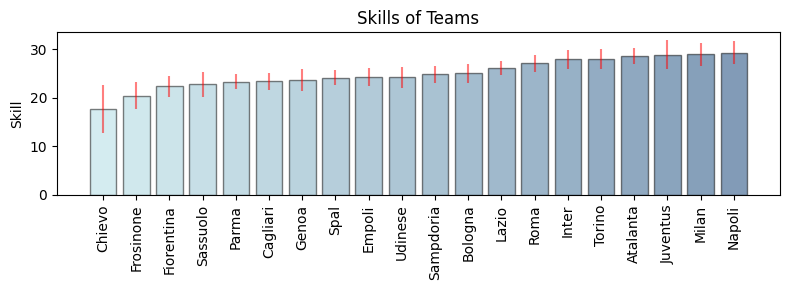

In [15]:
data = pd.read_csv('football_ranking.txt', sep=',', header=0).to_numpy()[:-2, :]
plot_skill(data, "football_ranking.pdf")

### Question 7: Prediction accuracy for the one-step-ahead procedure

In [16]:
with open("football_ranking.txt", "r") as f:
    last_line = f.readlines()[-1]
    print(last_line)

Prediction accuracy: 0.6544117647058824


### Question 11: Plot hyperparameter tuning if there was one (Question 11)

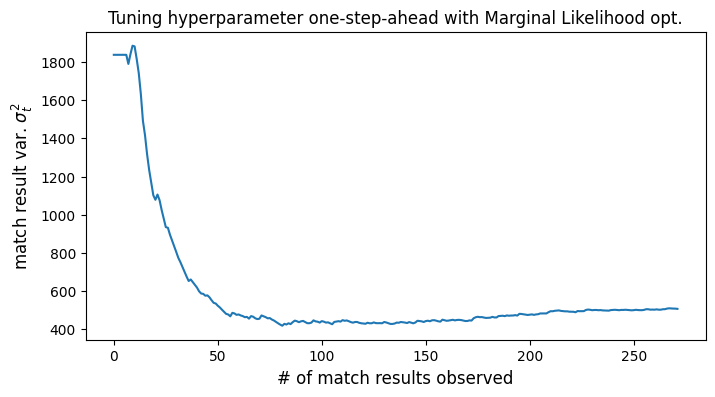

In [21]:
if TUNE_VAR:
    plt.figure(figsize=(8, 4))
    plt.plot(range(len(s_e_conv)), s_e_conv)
    plt.title("Tuning hyperparameter one-step-ahead with Marginal Likelihood opt.", fontsize=12)
    plt.xlabel("# of match results observed", fontsize=12)
    plt.ylabel("match result var. $\sigma_t^2$", rotation=90, fontsize=12)
    plt.show()

# Question 9

### Message-passing & moment-matching

In [25]:
# Function to update s1 distribution after win/loss is observed
def post_s1(mu1, mu2, v1, v2, s_e, y):
    b = np.sign(y) * np.sqrt(2 * (v1 + v2 + s_e) / np.pi)
    beta = (v1 + v2 + s_e) * (1 - 2 / np.pi)
    
    a = (b - (mu1 - mu2) * (1 - 2 / np.pi)) * np.pi / 2
    alpha = (v1 + v2 + s_e) * (np.pi / 2 - 1)
    
    m1 = (mu1 * (s_e + v2 + alpha) + (mu2 + a) * s_e) / (s_e + v2 + alpha + v1)
    v1 = v1 * (s_e + v2 + alpha) / (v1 + s_e + v2 + alpha)
    return m1, v1

# Function to update s2 distribution after win/loss is observed
def post_s2(mu1, mu2, v1, v2, s_e, y):
    b = np.sign(y) * np.sqrt(2 * (v1 + v2 + s_e) / np.pi)
    beta = (v1 + v2 + s_e) * (1 - 2 / np.pi)
    
    a = (b - (mu1 - mu2) * (1 - 2 / np.pi)) * np.pi / 2
    alpha = (v1 + v2 + s_e) * (np.pi / 2 - 1)
    
    m2 = (mu2 * (s_e + v1 + alpha) + (mu1 - a) * s_e) / (s_e + v1 + alpha + v2)
    v2 = v2 * (s_e + v1 + alpha) / (v2 + s_e + v1 + alpha)
    return m2, v2

In [26]:
# prior
m1, m2 = 0, 0
v1, v2 = 1, 1
s_e = 1

# observed results
ys = [1,]

for y in ys:     
    m1_new, v1_new = post_s1(m1, m2, v1, v2, s_e, y)
    m2_new, v2_new  = post_s2(m1, m2, v1, v2, s_e, y)
    
m1_mp = m1_new
v1_mp = v1_new
m2_mp = m2_new
v2_mp = v2_new

### Gibbs sampling to compare

In [30]:
def approx_gaussian(samples, importances):
    mu = np.average(samples, weights=importances)
    var = np.average((samples - mu) ** 2, weights=importances)
    return mu, var

def importance(s1, s2, s_e, y=1):
    pr = 1 - stats.norm(s1 - s2, s_e ** 0.5).cdf(0) if y > 0 else stats.norm(s1 - s2, s_e ** 0.5).cdf(0)
    return pr

In [32]:
# prior
m1, m2 = 0, 0
v1, v2 = 1, 1
s_e = 1

num_samples = 3000
drops = 1000

# observed results
ys = [1,]

for y in ys: 
    posterior = []
    post_weights = []
    s1 = 0
    s1_w = 1

    for _ in range(num_samples):
        s2 = stats.norm.rvs(m2, v2**0.5)
        s2_w = importance(s1, s2, s_e, y)
        
        posterior.append((s1, s2))
        post_weights.append((s1_w, s2_w))

        s1 = stats.norm.rvs(m1, v1**0.5)
        s1_w = importance(s1, s2, s_e, y)

    posterior = np.array(posterior)
    post_weights = np.array(post_weights)
    
    m1, v1 = approx_gaussian(posterior[drops:, 0], post_weights[drops:, 0])
    m2, v2 = approx_gaussian(posterior[drops:, 1], post_weights[drops:, 1])
    
m1_gibbs = m1
v1_gibbs = v1
m2_gibbs = m2
v2_gibbs = v2

### Plot message-passing vs. Gibbs sampling results

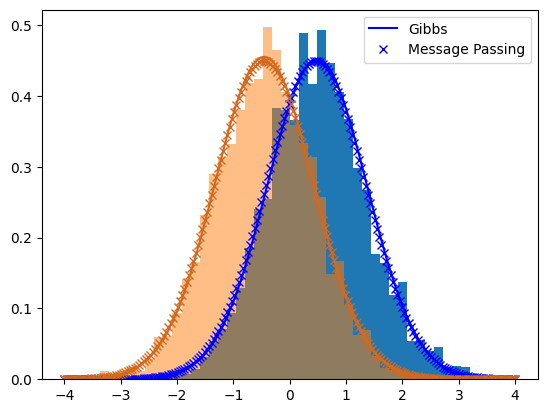

In [33]:
plt.hist(posterior[drops:,0], density=True, weights=post_weights[drops:,0], bins=50, range=(-4, 4))
plt.hist(posterior[drops:,1], density=True, weights=post_weights[drops:,1], bins=50, range=(-4, 4), alpha=0.5)

xs = np.linspace(-4, 4, 200)
gaussian1_gibbs = stats.norm(m1_gibbs, v1_gibbs**0.5).pdf(xs)
gaussian2_gibbs = stats.norm(m2_gibbs, v2_gibbs**0.5).pdf(xs)
plt.plot(xs, gaussian1_gibbs, color='blue', label='Gibbs')
plt.plot(xs, gaussian2_gibbs, color='chocolate')

gaussian1_mp = stats.norm(m1_mp, v1_mp**0.5).pdf(xs)
gaussian2_mp = stats.norm(m2_mp, v2_mp**0.5).pdf(xs)
plt.plot(xs, gaussian1_mp, 'x', color='blue', label='Message Passing')
plt.plot(xs, gaussian2_mp, 'x', color='chocolate')

plt.legend()

### we see that two types of line, posterior from Gibbs sampling and from Moment-matching, coincide

# Question10

In [34]:
pd.set_option("display.max_rows", 100)

### Model classes

In [35]:
S_E = 100/4

class Skill:
    def __init__(self, mu=100, var=100):
        self.mu = mu
        self.var = var


class Team:
    def __init__(self, name, skill):
        self.name = name
        self.skill = skill

    def predict(self, another):
        lose_rate = stats.norm.cdf(x=0,
                                   loc=self.skill.mu - another.skill.mu,
                                   scale=(self.skill.var + another.skill.var + S_E) ** 0.5)
        win_rate = 1 - lose_rate
        return win_rate

    def update(self, another, result, num_samples=3000, drops=1000):
        posterior = []
        post_weights = []
        s1 = self.skill.mu
        s1_w = self.skill.var

        for _ in range(num_samples):
            s2 = stats.norm.rvs(another.skill.mu, another.skill.var ** 0.5)
            s2_w = self._importance(s1, s2, result)

            posterior.append((s1, s2))
            post_weights.append((s1_w, s2_w))

            s1 = stats.norm.rvs(self.skill.mu, self.skill.var ** 0.5)
            s1_w = self._importance(s1, s2, result)

        posterior = np.array(posterior)
        post_weights = np.array(post_weights)

        self.skill.mu, self.skill.var = self._approx_gaussian(posterior[drops:, 0], post_weights[drops:, 0])
        another.skill.mu, another.skill.var = self._approx_gaussian(posterior[drops:, 1], post_weights[drops:, 1])

    @staticmethod
    def _approx_gaussian(samples, importances):
        mu = np.average(samples, weights=importances)
        var = np.average((samples - mu) ** 2, weights=importances)
        return mu, var

    @staticmethod
    def _importance(s1, s2, y=1):
        pr = 1 - stats.norm(s1 - s2, S_E ** 0.5).cdf(0) if y > 0 else stats.norm(s1 - s2, S_E ** 0.5).cdf(0)
        return pr

### Data preparation and exploration

In [36]:
#raw data
nba=pd.read_csv('./nba-2021-UTC.csv', sep=',', header=0)
nba

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result
0,1,1,19/10/2021 23:30,Fiserv Forum,Milwaukee Bucks,Brooklyn Nets,127 - 104
1,2,1,20/10/2021 02:00,STAPLES Center,Los Angeles Lakers,Golden State Warriors,114 - 121
2,3,1,20/10/2021 23:00,Spectrum Center,Charlotte Hornets,Indiana Pacers,123 - 122
3,4,1,20/10/2021 23:00,Little Caesars Arena,Detroit Pistons,Chicago Bulls,88 - 94
4,5,1,20/10/2021 23:30,Madison Square Garden,New York Knicks,Boston Celtics,138 - 134
...,...,...,...,...,...,...,...
1225,1220,24,11/04/2022 01:30,Ball Arena,Denver Nuggets,Los Angeles Lakers,141 - 146
1226,1222,24,11/04/2022 01:30,Crypto.com Arena,LA Clippers,Oklahoma City Thunder,138 - 88
1227,1225,24,11/04/2022 01:30,Smoothie King Center,New Orleans Pelicans,Golden State Warriors,107 - 128
1228,1229,24,11/04/2022 01:30,Footprint Center,Phoenix Suns,Sacramento Kings,109 - 116


In [37]:
nba['Home Team'].describe()

count                1230
unique                 30
top       Milwaukee Bucks
freq                   41
Name: Home Team, dtype: object

In [38]:
# split result into team1 score and team2 score
nba['Score1']=nba['Result'].map(lambda x: x.split()[0])
nba['Score2']=nba['Result'].map(lambda x: x.split()[2])
nba

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,Score1,Score2
0,1,1,19/10/2021 23:30,Fiserv Forum,Milwaukee Bucks,Brooklyn Nets,127 - 104,127,104
1,2,1,20/10/2021 02:00,STAPLES Center,Los Angeles Lakers,Golden State Warriors,114 - 121,114,121
2,3,1,20/10/2021 23:00,Spectrum Center,Charlotte Hornets,Indiana Pacers,123 - 122,123,122
3,4,1,20/10/2021 23:00,Little Caesars Arena,Detroit Pistons,Chicago Bulls,88 - 94,88,94
4,5,1,20/10/2021 23:30,Madison Square Garden,New York Knicks,Boston Celtics,138 - 134,138,134
...,...,...,...,...,...,...,...,...,...
1225,1220,24,11/04/2022 01:30,Ball Arena,Denver Nuggets,Los Angeles Lakers,141 - 146,141,146
1226,1222,24,11/04/2022 01:30,Crypto.com Arena,LA Clippers,Oklahoma City Thunder,138 - 88,138,88
1227,1225,24,11/04/2022 01:30,Smoothie King Center,New Orleans Pelicans,Golden State Warriors,107 - 128,107,128
1228,1229,24,11/04/2022 01:30,Footprint Center,Phoenix Suns,Sacramento Kings,109 - 116,109,116


In [39]:
(nba['Score1'].astype('int').sum()+nba['Score2'].astype('int').sum())/2460
#average score

110.6349593495935

In [40]:
nba['Score1'].astype('int').var(),nba['Score2'].astype('int').var()

(155.48693894831544, 162.37714911323238)

In [41]:
nba.loc[nba['Score1']==nba['Score2']]
#no draws, perfect dataset

,Match Number,Round Number,Date,Location,Home Team,Away Team,Result,Score1,Score2


### Training and prediction

In [43]:
teams = {name: Team(name, Skill()) for name in nba['Home Team'].unique()}

num_predictions = 0
correct_predictions = 0

for num in nba.index:
    #load match
    match=nba[num:num+1]
    team1 = teams[match['Home Team'].item()]
    team2 = teams[match['Away Team'].item()]

    # skip draws
    if match['Score1'].astype('int').item() == match['Score2'].astype('int').item():
        continue

    num_predictions += 1
    result = 1 if match['Score1'].astype('int').item() > match['Score2'].astype('int').item() else -1
#     print(f"Before match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
#           f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")
#     print(f"Team 1 rate: {round(team1.predict(team2), 2)} ==================== Result: {result}")

    prediction = 1 if team1.predict(team2) >= 0.5 else -1

    correct_predictions += prediction == result
    # update skills
    team1.update(team2, result)
#     print(f"After match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
#           f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")

#     print("=======================================================")

### Prediction accuracy

In [44]:
correct_predictions/num_predictions

0.6138211382113821

In [45]:
skills=pd.DataFrame({'Team':teams.keys()})
skills['Mean']=[teams[skills['Team'][i:i+1].item()].skill.mu for i in range(len(skills))]
skills['Varience']=[teams[skills['Team'][i:i+1].item()].skill.var for i in range(len(skills))]

In [46]:
skills['Mean'].sum()/30

100.35399369902036

In [47]:
skills['Varience'].sum()/30

0.599400401494992

In [48]:
skills.sort_values(by='Mean',ascending=False)

,Team,Mean,Varience
11,Phoenix Suns,104.728799,0.678741
6,Memphis Grizzlies,102.777297,0.607687
29,Dallas Mavericks,102.419316,0.619359
19,Boston Celtics,102.403735,0.518839
14,Miami Heat,102.395022,0.487208
0,Milwaukee Bucks,102.393367,0.661058
20,Philadelphia 76ers,102.109259,0.479384
15,Golden State Warriors,102.006953,0.593282
5,Toronto Raptors,101.820386,0.793851
10,Utah Jazz,101.495084,0.496762


In [49]:
skills.to_csv('skill_nba.csv',index=False)

### Plot posterior distributions for skills

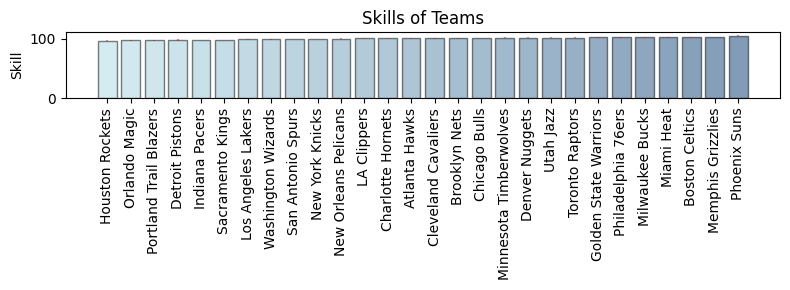

In [50]:
data = pd.read_csv('skill_nba.csv', sep=',', header=0).to_numpy()[:-2, :]

data = data[data[:, 1].argsort()]

plt.figure(figsize=(8, 3))

color1 = "#abdbe3"
color2 = "#063970"


plt.bar(data[:, 0], data[:, 1], yerr=data[:, 2]**0.5, alpha=0.5, align='center',
           color=get_color_gradient(color1, color2, len(data[:, 0])), edgecolor="black",
           error_kw=dict(ecolor='red', alpha=0.5))
plt.xticks(rotation=90)
plt.ylabel("Skill")
plt.title("Skills of Teams")

# Save the figure and show
plt.tight_layout()
plt.savefig('skill_ranking_nba.pdf', dpi=500)

### Run another round using different order

In [51]:
nba=nba.sample(frac=1)

teams = {name: Team(name, Skill()) for name in nba['Home Team'].unique()}

num_predictions = 0
correct_predictions = 0

for num in nba.index:
    #load match
    match=nba[num:num+1]
    team1 = teams[match['Home Team'].item()]
    team2 = teams[match['Away Team'].item()]

    # skip draws
    if match['Score1'].astype('int').item() == match['Score2'].astype('int').item():
        continue

    num_predictions += 1
    result = 1 if match['Score1'].astype('int').item() > match['Score2'].astype('int').item() else -1
#     print(f"Before match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
#           f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")
#     print(f"Team 1 rate: {round(team1.predict(team2), 2)} ==================== Result: {result}")

    prediction = 1 if team1.predict(team2) >= 0.5 else -1

    correct_predictions += prediction == result
    # update skills
    team1.update(team2, result)
#     print(f"After match: {team1.name}: {round(team1.skill.mu, 2)}-{round(team1.skill.var, 2)} vs "
#           f"{team2.name}: {round(team2.skill.mu, 2)}-{round(team2.skill.var, 2)}")

#     print("=======================================================")

### Prediction accuracy

In [52]:
correct_predictions/num_predictions

0.6203252032520326

### Plot posterior distributions for skills

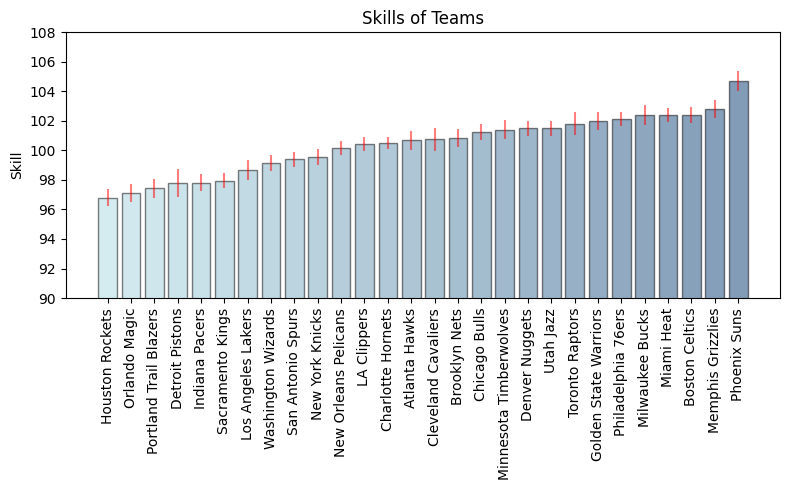

In [53]:
data = pd.read_csv('skill_nba.csv', sep=',', header=0).to_numpy()[:-2, :]

data = data[data[:, 1].argsort()]

plt.figure(figsize=(8, 5))

color1 = "#abdbe3"
color2 = "#063970"


plt.bar(data[:, 0], data[:, 1], yerr=data[:, 2]**0.5, alpha=0.5, align='center',
           color=get_color_gradient(color1, color2, len(data[:, 0])), edgecolor="black",
           error_kw=dict(ecolor='red', alpha=0.5))
plt.xticks(rotation=90)
plt.ylim(90,108)
plt.ylabel("Skill")
plt.title("Skills of Teams")

# Save the figure and show
plt.tight_layout()
plt.savefig('skill_ranking_nba.pdf', dpi=500)